In [309]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

### 点分类

Cora数据集是PyG内置的节点分类数据集，代表着学术论文的相关性分类问题（即把每一篇学术论文都看成是节点），
Cora数据集有2708个节点，1433维特征，边数为5429。标签是文献的主题，共计 7 个类别。所以这是一个7分类问题。

In [310]:
#载入数据
dataset = Planetoid(root='~/tmp/Cora', name='Cora')
data = dataset[0]

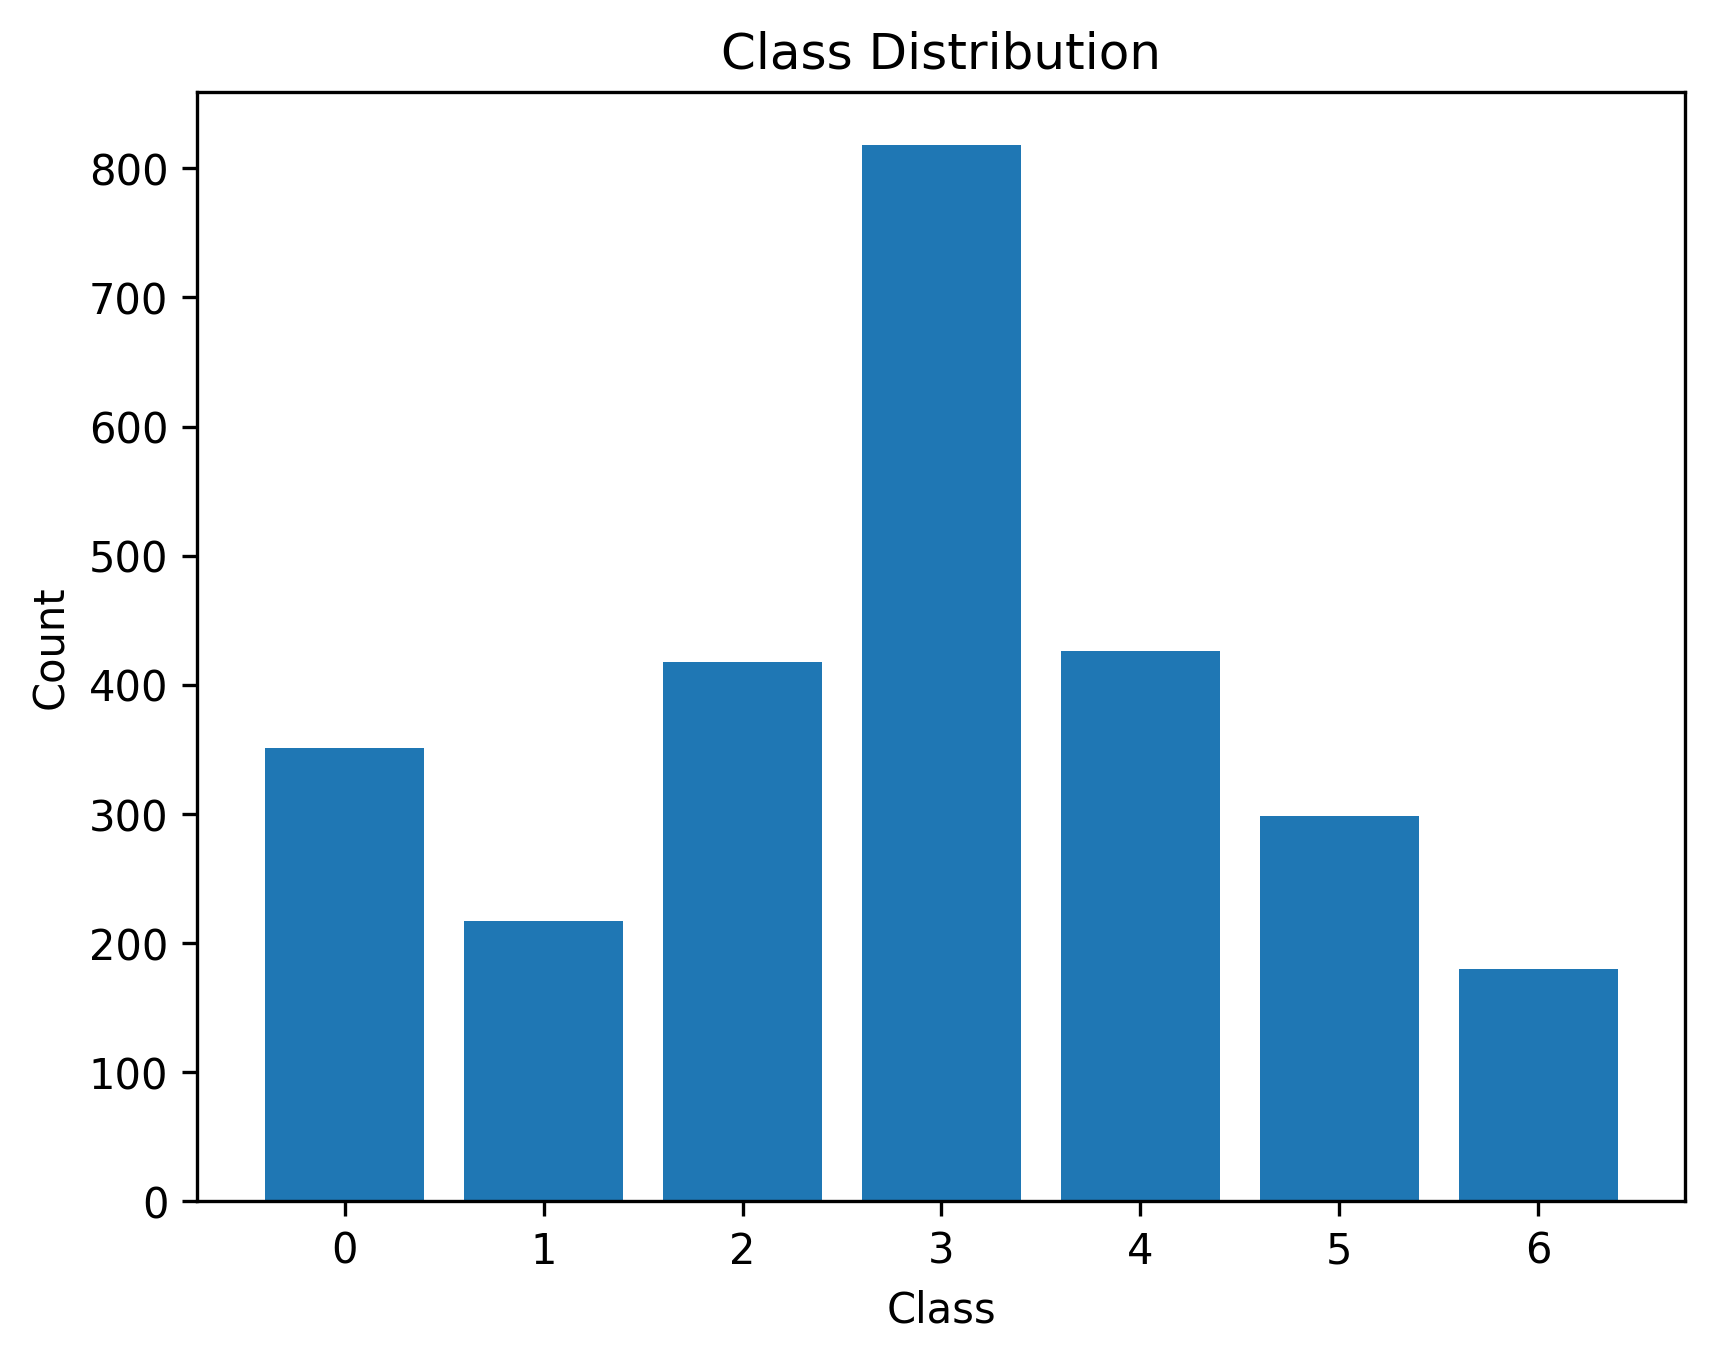

In [311]:
import matplotlib.pyplot as plt
# 计算唯一的类别和它们的数量
classes, counts = torch.unique(data.y, return_counts=True)
# 绘制直方图
plt.bar(classes, counts)
# 设置轴标签和标题
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
# 显示图形
plt.show()

七个主题：
    1.`Case_Based`：以案例为基础的推理。
    2.`Genetic_Algorithms`：遗传算法和进化计算。
    3.`Neural_Networks`：神经网络和深度学习。
    4.`Probabilistic_Methods`：概率方法和统计推断。
    5.`Reinforcement_Learning`：强化学习和增强学习。
    6.`Rule_Learning`：规则学习和归纳逻辑编程。
    7.`Theory`：机器学习理论和分析。

In [312]:
#定义网络架构
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = GCNConv(dataset.num_features, 16)  
#         self.conv2 = GCNConv(16, dataset.num_classes)
#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

In [313]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4层 每个节点周围（距离4个“跳”为止的所有节点）汇总4跳邻域信息。
        self.conv1 = GCNConv(dataset.num_features, 64)
        self.conv2 = GCNConv(64, 32)  # 添加一层
        self.conv3 = GCNConv(32, 16)  # 添加一层 
        self.conv4 = GCNConv(16, dataset.num_classes)  # 添加一层，输出维度为类别数
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)


In [314]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [315]:
model.train()

losses = []  # 用于保存每个 epoch 的损失值

for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # 将当前 epoch 的损失值添加到列表中

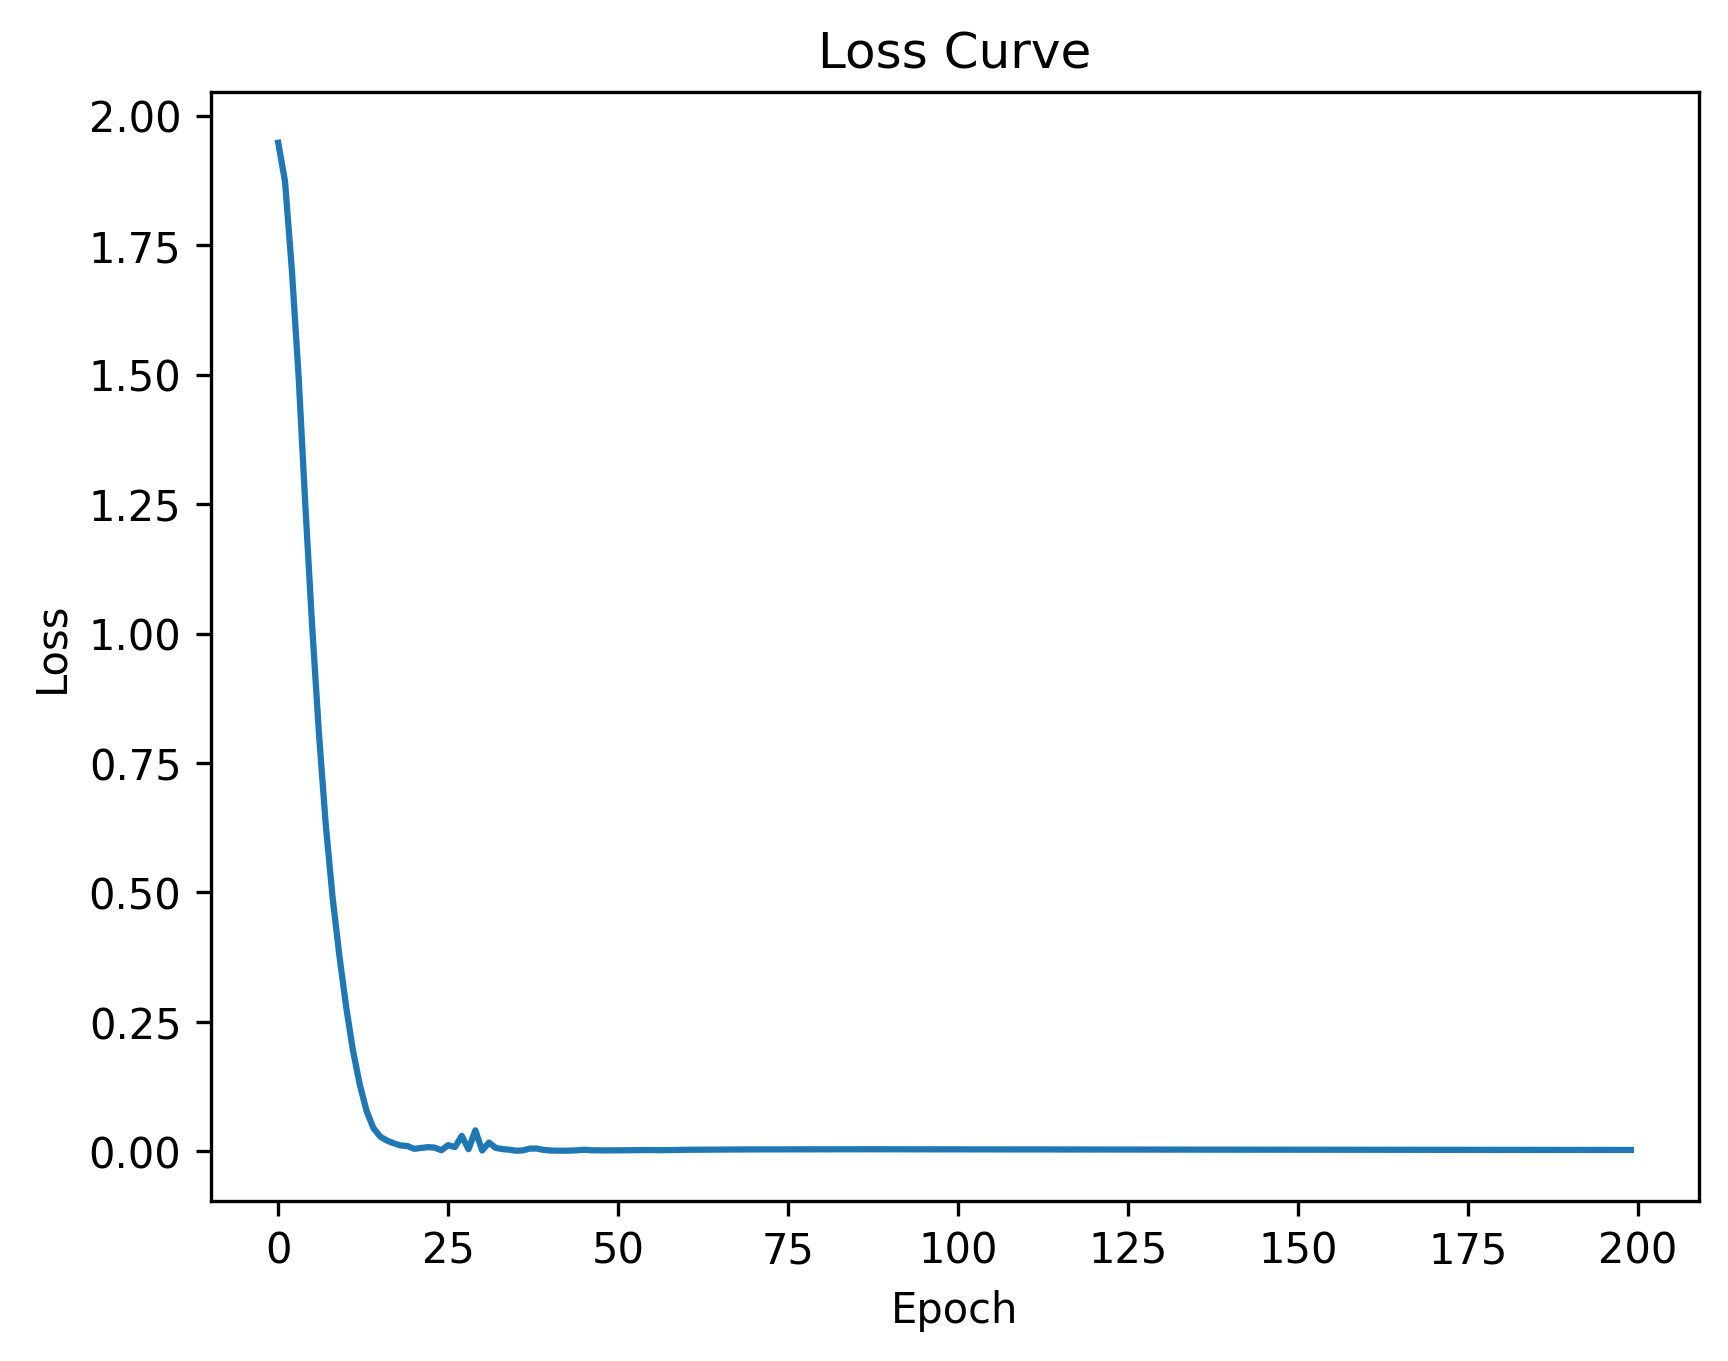

In [316]:
import matplotlib.pyplot as plt
# 绘制 loss 曲线
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [317]:
#测试：
model.eval()
test_predict = model(data.x, data.edge_index)[data.test_mask]
max_index = torch.argmax(test_predict, dim=1)
test_true = data.y[data.test_mask]
correct = 0
for i in range(len(max_index)):
    if max_index[i] == test_true[i]:
        correct += 1
print('测试集准确率为：{}%'.format(correct*100/len(test_true)))

测试集准确率为：78.2%


### 边分类

In [318]:
from torch_geometric.utils import negative_sampling### 边分类

In [319]:
class EdgeClassifier(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EdgeClassifier, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)
        self.classifier = torch.nn.Linear(2 * out_channels, 2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv(x, edge_index))
        pos_edge_index = edge_index
        total_edge_index = torch.cat(
            [pos_edge_index, negative_sampling(edge_index, num_neg_samples=pos_edge_index.size(1))], dim=1)
        edge_features = torch.cat([x[total_edge_index[0]], x[total_edge_index[1]]], dim=1)
        return self.classifier(edge_features)

In [320]:
# 加载数据集
dataset = Planetoid(root='~/tmp/Cora', name='Cora')
data = dataset[0]

In [321]:
# 创建train_mask和test_mask
edges = data.edge_index.t().cpu().numpy()
num_edges = edges.shape[0]
train_mask = torch.zeros(num_edges, dtype=torch.bool)
test_mask = torch.zeros(num_edges, dtype=torch.bool)
train_size = int(0.8 * num_edges)
train_indices = torch.randperm(num_edges)[:train_size]
train_mask[train_indices] = True
test_mask[~train_mask] = True

In [322]:
# 定义模型和优化器/训练/测试
model = EdgeClassifier(dataset.num_features, 64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [323]:
def train_Edge():
    model.train()
    optimizer.zero_grad()
    logits = model(data.x, data.edge_index)
    pos_edge_index = data.edge_index
    pos_labels = torch.ones(pos_edge_index.size(1), dtype=torch.long)
    neg_labels = torch.zeros(pos_edge_index.size(1), dtype=torch.long)
    labels = torch.cat([pos_labels, neg_labels], dim=0).to(logits.device)
    new_train_mask = torch.cat([train_mask, train_mask], dim=0)
    loss = F.cross_entropy(logits[new_train_mask], labels[new_train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [324]:
def test():
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pos_edge_index = data.edge_index
        pos_labels = torch.ones(pos_edge_index.size(1), dtype=torch.long)
        neg_labels = torch.zeros(pos_edge_index.size(1), dtype=torch.long)
        labels = torch.cat([pos_labels, neg_labels], dim=0).to(logits.device)
        new_test_mask = torch.cat([test_mask, test_mask], dim=0)

        predictions = logits[new_test_mask].max(1)[1]
        correct = predictions.eq(labels[new_test_mask]).sum().item()
        return correct / len(predictions)

In [325]:
losses = []  # 保存每个 epoch 的损失值
accuracies = []  # 保存每个 epoch 的准确率

for epoch in range(1, 1001):
    loss = train_Edge()
    acc = test()

    losses.append(loss)  # 将当前 epoch 的损失值添加到列表中
    accuracies.append(acc)  # 将当前 epoch 的准确率添加到列表中

    if epoch % 50 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}")

Epoch: 050, Loss: 0.5473, Acc: 0.7109
Epoch: 100, Loss: 0.5549, Acc: 0.6892
Epoch: 150, Loss: 0.5403, Acc: 0.6903
Epoch: 200, Loss: 0.5388, Acc: 0.6813
Epoch: 250, Loss: 0.5369, Acc: 0.6934
Epoch: 300, Loss: 0.5441, Acc: 0.6804
Epoch: 350, Loss: 0.5373, Acc: 0.6813
Epoch: 400, Loss: 0.5350, Acc: 0.6851
Epoch: 450, Loss: 0.5385, Acc: 0.6825
Epoch: 500, Loss: 0.5390, Acc: 0.6804
Epoch: 550, Loss: 0.5365, Acc: 0.6723
Epoch: 600, Loss: 0.5330, Acc: 0.6896
Epoch: 650, Loss: 0.5366, Acc: 0.6844
Epoch: 700, Loss: 0.5336, Acc: 0.6697
Epoch: 750, Loss: 0.5381, Acc: 0.6697
Epoch: 800, Loss: 0.5305, Acc: 0.6757
Epoch: 850, Loss: 0.5363, Acc: 0.6705
Epoch: 900, Loss: 0.5361, Acc: 0.6731
Epoch: 950, Loss: 0.5363, Acc: 0.6747
Epoch: 1000, Loss: 0.5395, Acc: 0.6861


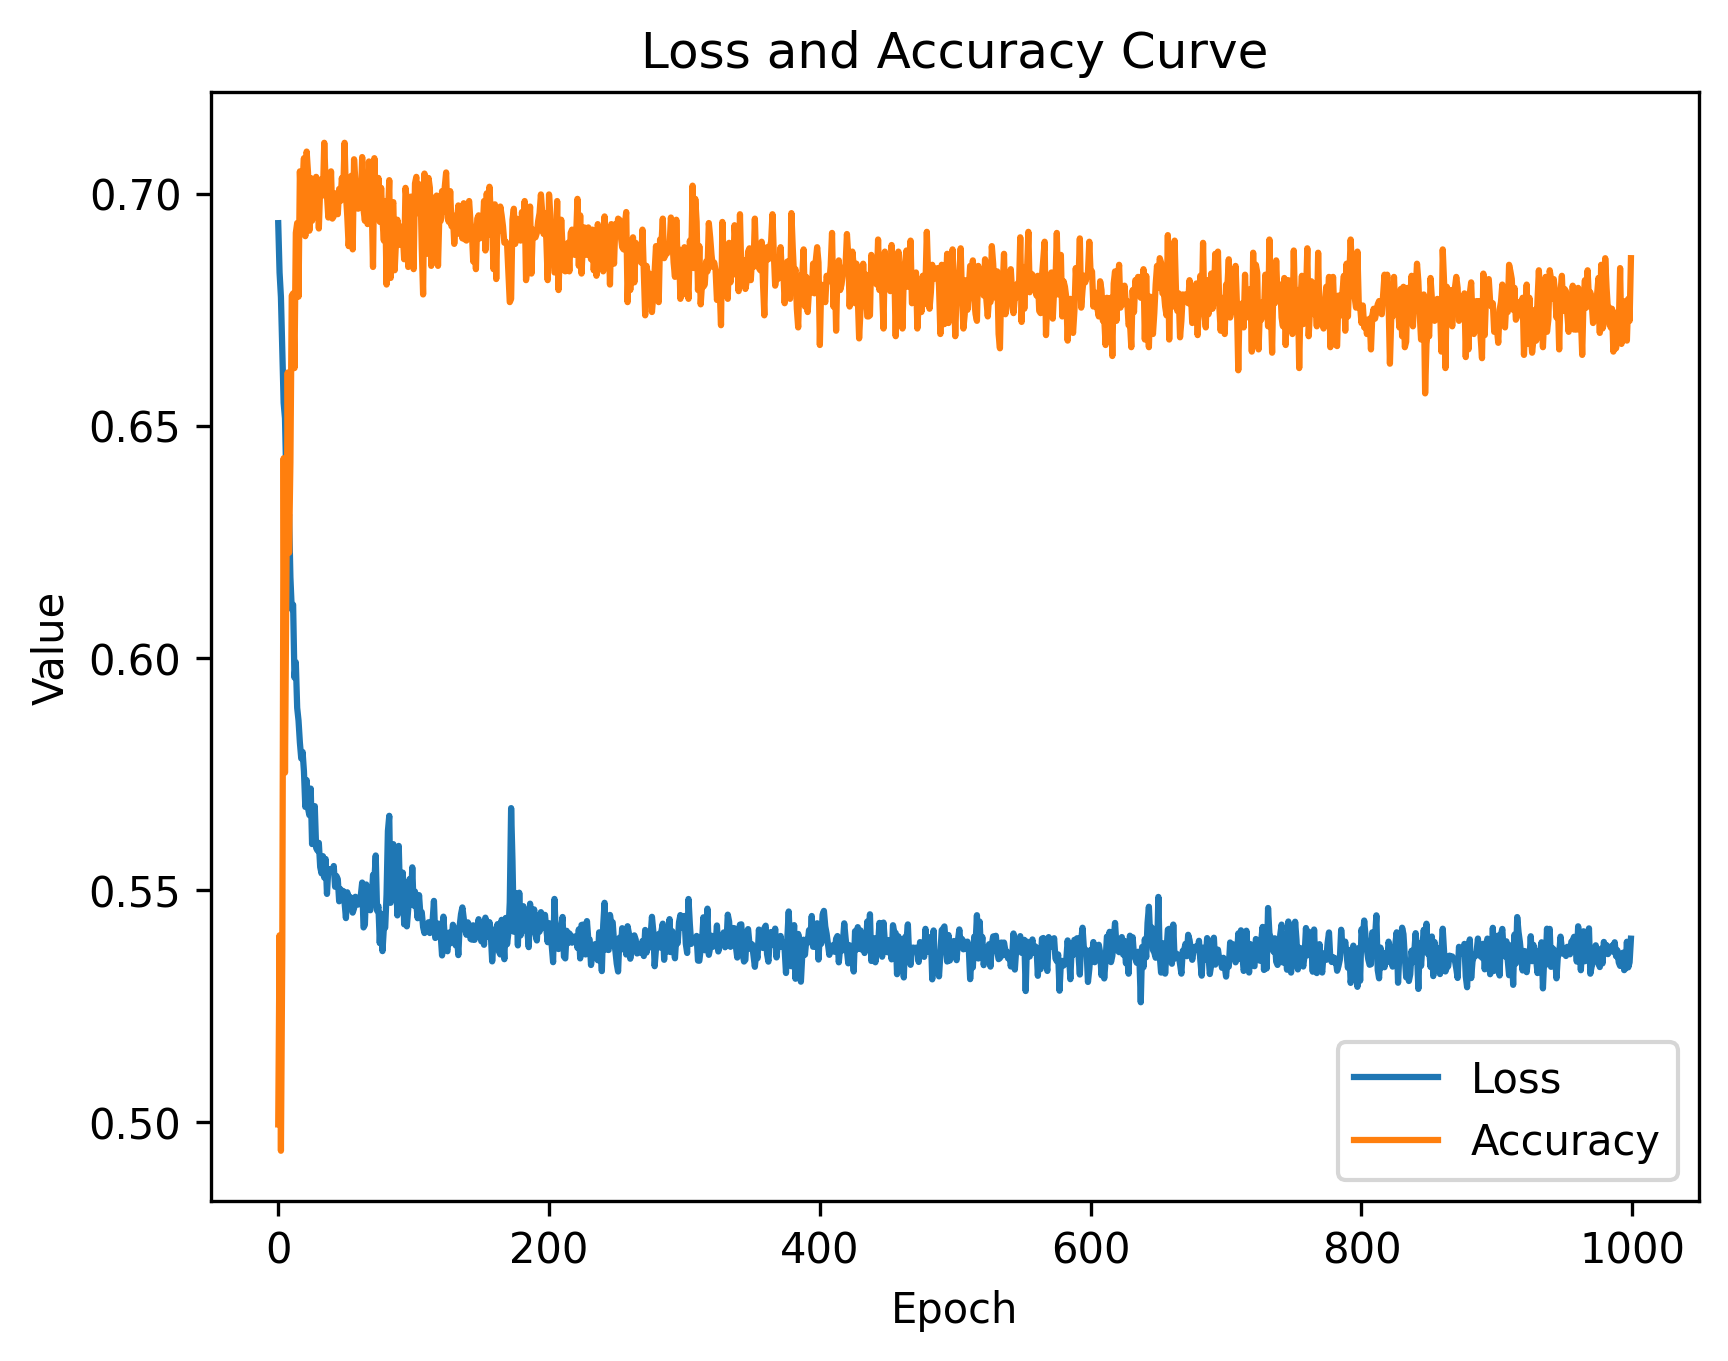

In [326]:
# 绘制 loss 曲线和准确率曲线
plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy Curve')
plt.legend()
plt.show()

### 图分类

In [327]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

ENZYMES数据集是在GNN领域是非常经典的数据集，它是一个根据生物分子蛋白质结构而构建的Graph数据集合，总共600个图，也就是对应600个样本（蛋白质分子） ，共有六种结构

In [328]:
# 加载数据集
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()

train_dataset = dataset[:450]
test_dataset = dataset[450:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [329]:
data = dataset.data
data

Data(x=[19580, 3], edge_index=[2, 74564], y=[600])

数据集的节点特征矩阵的维度为【19580，3】，代表这个数据集（600张图一共）有19580个节点，每个节点的特征维度为3，共有74564条边，这些数据并不是一个图的，而是ENZYMES600张图加起来一共的。

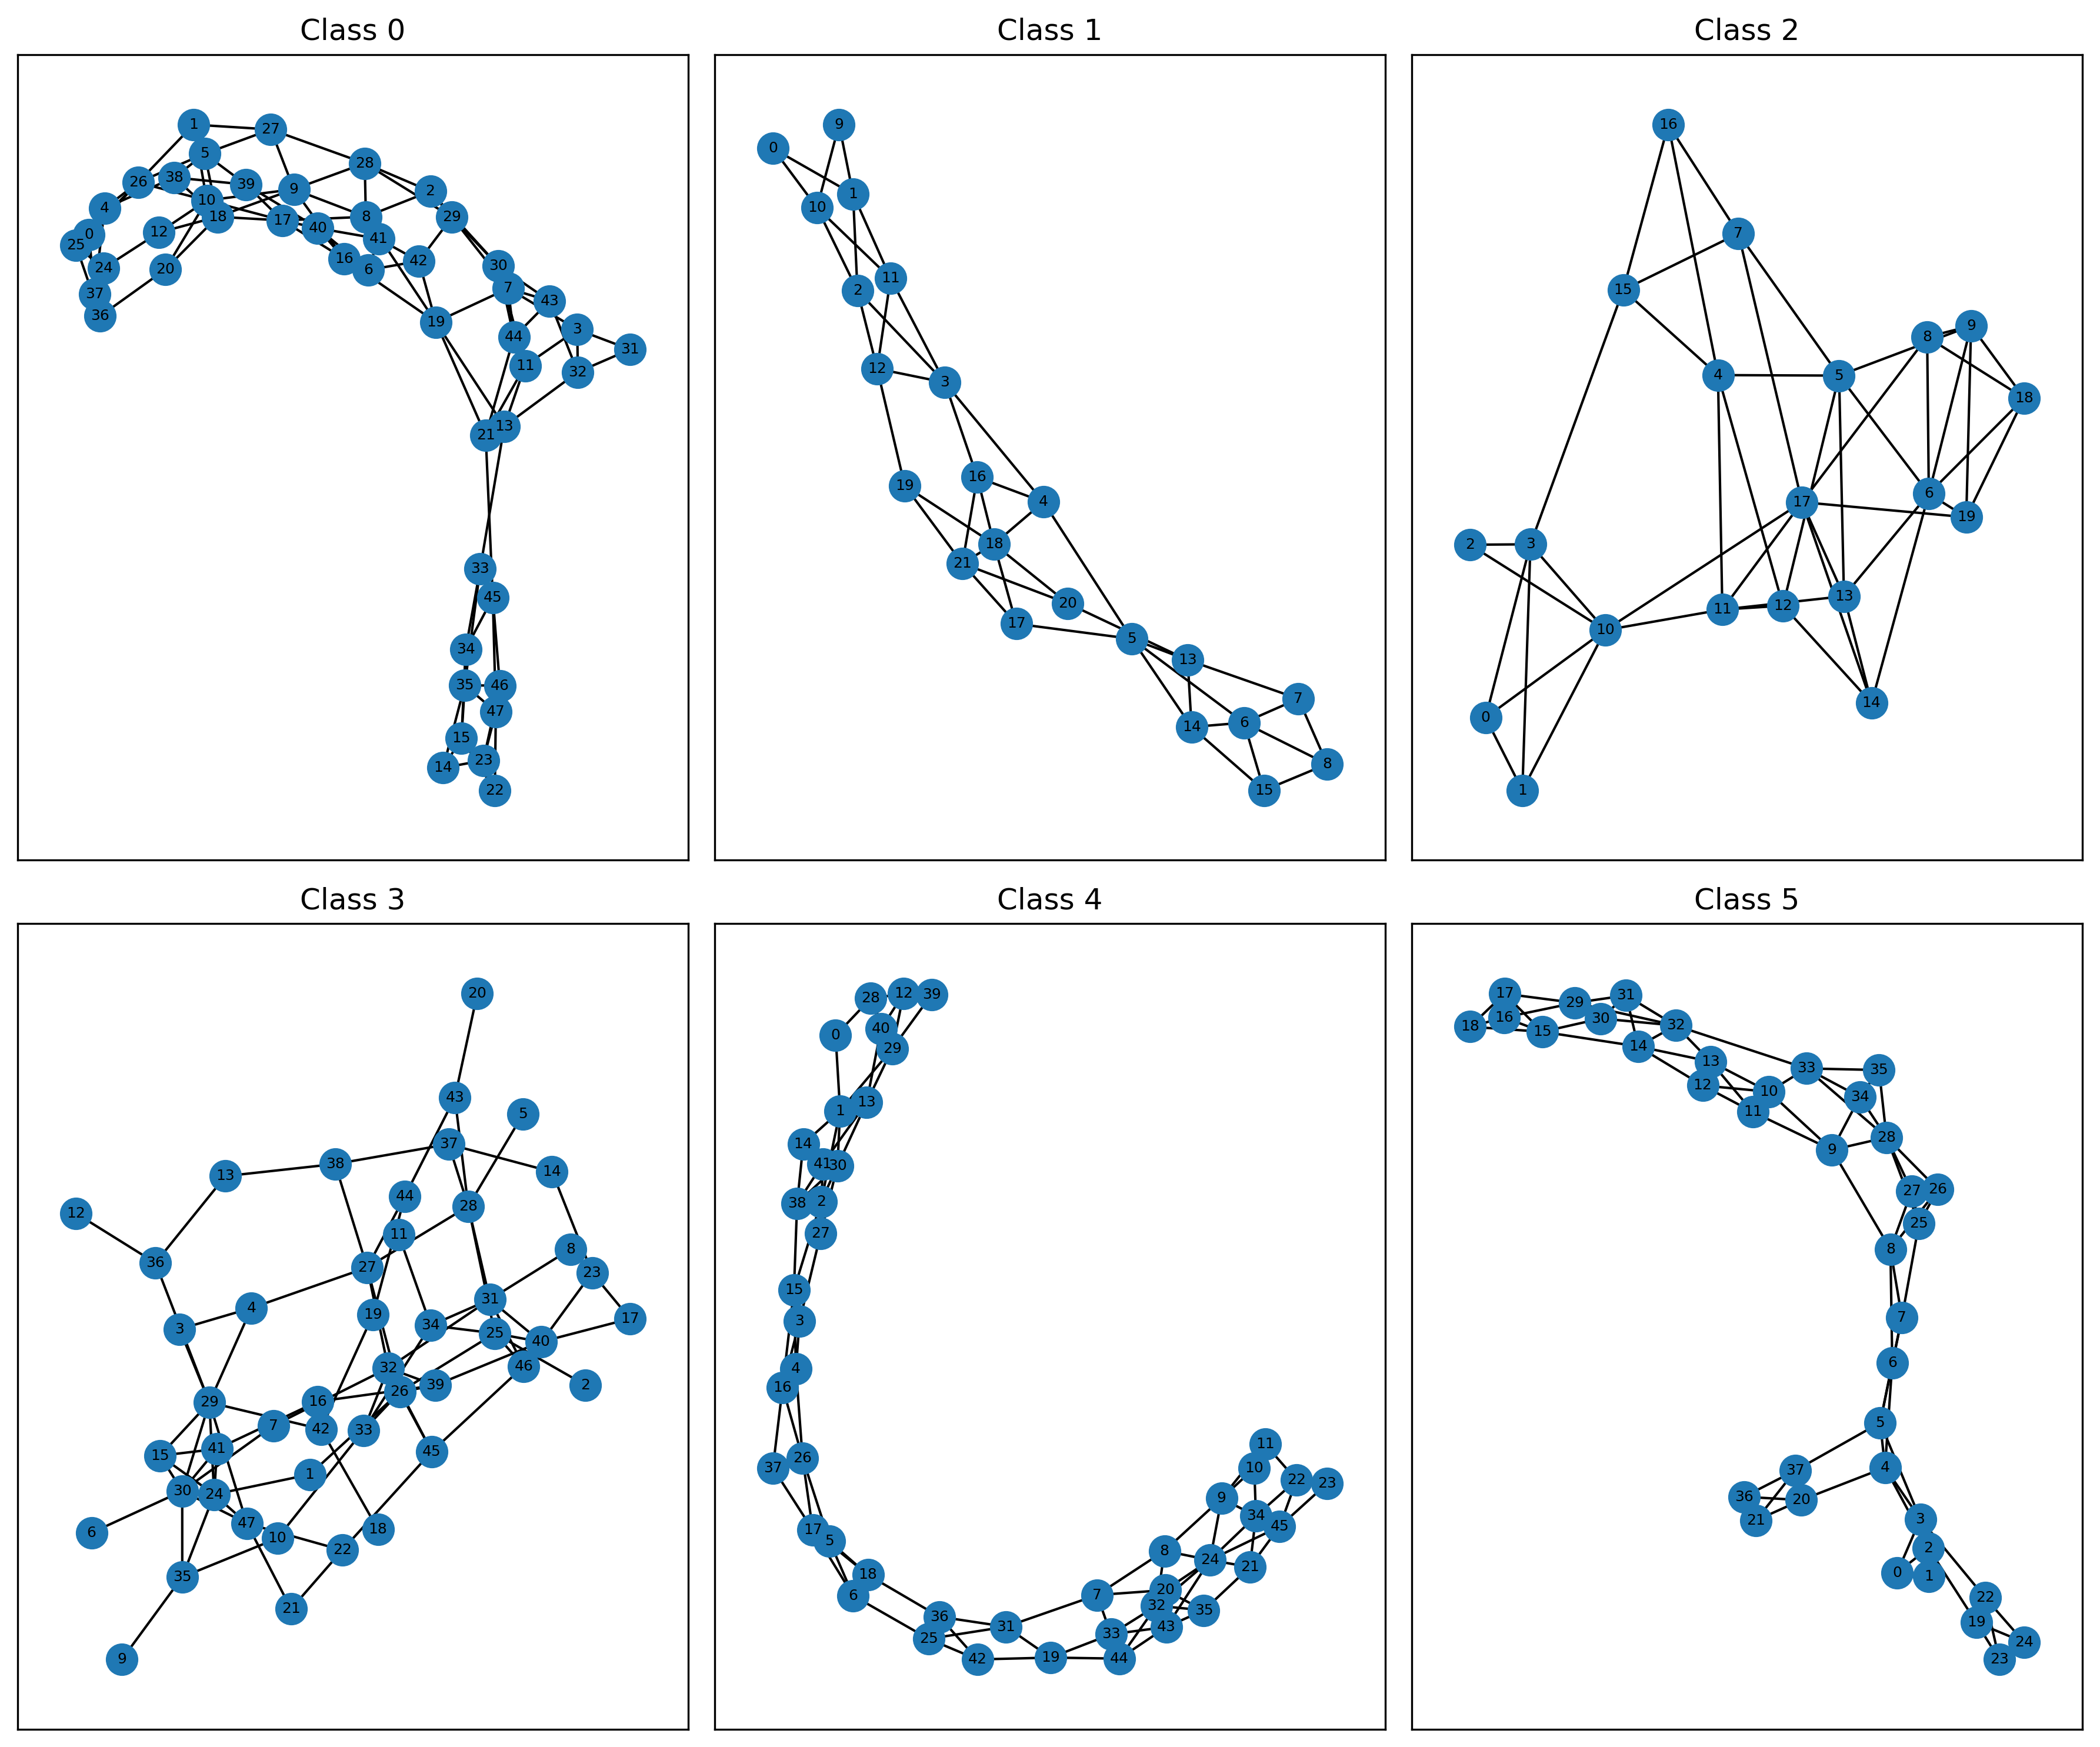

In [330]:
import random
import networkx as nx
# 获取每个类别中的一张图
class_indices = [[] for _ in range(dataset.num_classes)]
for i, data in enumerate(dataset):
    class_idx = data.y.item()
    class_indices[class_idx].append(i)
    
graphs = []
for indices in class_indices:
    if indices:
        idx = random.choice(indices)
        graphs.append(dataset[idx])

# 可视化每个图
plt.figure(figsize=(12, 10))
for i, graph in enumerate(graphs):
    plt.subplot(2, 3, i+1)
    edge_index = graph.edge_index
    source = edge_index[0]
    target = edge_index[1]
    g = nx.Graph()
    for src, tge in zip(source, target):
        g.add_edge(src.item(), tge.item())
    nx.draw_networkx(G=g, node_size=150, font_size=6)
    plt.title(f'Class {graph.y.item()}')
plt.tight_layout()
plt.show()


In [331]:
from torch.nn import Linear
# 定义图卷积网络模型
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=-1)

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=6, bias=True)
)


In [332]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct = 0
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

for epoch in range(1, 1001):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# ================== 分割线 ===============

In [335]:
# 导入需要的包，遇到安装问题可在官方文档或其他文章查找解决方案
import torch
import torch.nn.functional as F
# 导入GCN层、GraphSAGE层和GAT层
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.datasets import Planetoid

# 加载数据集
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()

train_dataset = dataset[:450]
test_dataset = dataset[450:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

data = dataset.data

class GraphSAGE_NET(torch.nn.Module):

    def __init__(self, feature, hidden, classes):
        super(GraphSAGE_NET, self).__init__()
        self.sage1 = SAGEConv(feature, hidden)  # 定义两层GraphSAGE层
        self.sage2 = SAGEConv(hidden, classes)

    def forward(self, x, edge_index, batch):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.sage2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE_NET(dataset.num_node_features, 64, dataset.num_classes).to(device)  # 定义GraphSAGE
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct = 0
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

for epoch in range(1, 1001):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

ValueError: Expected input batch_size (1999) to match target batch_size (64).